In [81]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import torch
import pandas as pd
import copy
from voltron.option_utils import GetTradingDays, GetTrainingData, Pricer, FindLastTradingDays

In [82]:
def ComputeStratReturns(df):
    cumrtn = copy.deepcopy(df.Return.to_numpy() - df.Ask.to_numpy())
    cumrtn[df.Model < df.Ask] = 0.
    df['rtn'] = cumrtn
    df["cumrtn"] = np.cumsum(cumrtn)
    
def FilteredReturns(df):
    rtn = (df.Return.to_numpy() - df.Ask.to_numpy())/df.Ask.to_numpy()
    rtn[df.Model < df.Ask] = 0.
    return rtn
    
def AddData(logger, data, name):
    cols = data.columns.to_numpy()
    cols[4] = "Model"
    data.columns = cols
    data['Close'] = SPY[SPY['Date']==quotedate].Close.item()
    data["Type"] = name
    data['diffs'] = np.abs(data.Model - data.Return)
    data["Year"] = year
    ComputeStratReturns(data)
    


In [83]:
def LoadData(fname, quotedate, name, all_dat, type_dat):
    curr_dat = pd.read_pickle(fname)
    cols = curr_dat.columns.to_numpy()
    cols[4] = "Model"
    curr_dat.columns = cols
    curr_dat['Close'] = SPY[SPY['Date']==quotedate].Close.item()
    curr_dat["Type"] = name
    curr_dat['diffs'] = np.abs(mat_dat.Model - mat_dat.Return)
    curr_dat["Year"] = year
    ComputeStratReturns(curr_dat)
    
    if name != "SABR":
        ec = [d.item() for d in curr_dat.ExpClose.to_numpy()]
        curr_dat.ExpClose = ec
        
    type_dat = pd.concat((type_dat, curr_dat), ignore_index=True)
    all_dat = pd.concat((all_dat, curr_dat), ignore_index=True)
    
    return all_dat, type_dat

In [182]:
# years = [2010,2011,2012,2013,2014,2015]
years = np.arange(2006, 2018)
logger = []
all_dat = pd.DataFrame()
matern = pd.DataFrame()
sm = pd.DataFrame()
voltron = pd.DataFrame()
sabr = pd.DataFrame()

SPY = pd.read_csv("./data/SPY_prices.csv")
SPY['Date'] = pd.to_datetime(SPY['Date'])

for year in years:
    
    dat = pd.read_csv("./data/SPY_" + str(year) + ".csv")
    quotedate = pd.Timestamp(dat.quotedate.unique()[0])

    all_dat, sm = LoadData("./output/SM_options" + str(year) + ".pkl",
                  quotedate, "SM", all_dat, sm)
    all_dat, matern = LoadData("./output/matern_options" + str(year) + ".pkl",
                  quotedate, "Matern", all_dat, matern)
    all_dat, voltron = LoadData("./output/options" + str(year) + ".pkl",
                  quotedate, "Voltron", all_dat, voltron)
    all_dat, sabr = LoadData("./output/sabr" + str(year) + ".pkl",
                      quotedate, "SABR", all_dat, sabr)
    
    
#     all_dat = pd.concat((all_dat, mat_dat), ignore_index=True)
    
# ec = [d.item() for d in all_dat.ExpClose.to_numpy()]
# all_dat.ExpClose = ec

/Users/gregorybenton/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Calibration Plots

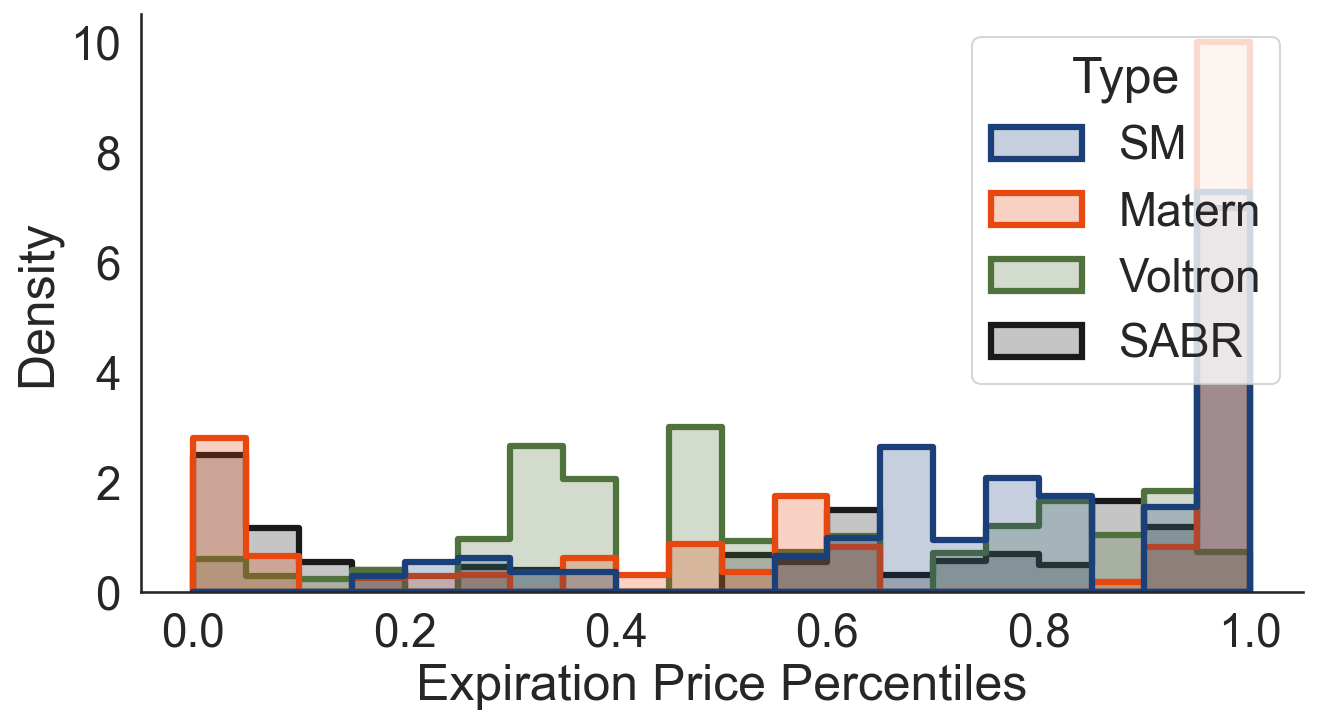

In [44]:
colors = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]

sns.set(font_scale=2.0, style="white", rc={"lines.linewidth": 4.0})


vidx = 0
sidx = 6
midx = 2

fig, ax = plt.subplots(1,1,dpi=150, figsize=(10, 5))
sns.histplot(x="Sample_Percentile", data=all_dat, hue="Type",
            stat="density", bins=20, common_norm=False, element="step",
            palette=[colors[vidx], colors[sidx], colors[midx], 'k'],
            lw=3., alpha=0.25)
sns.despine()

# legend_elements = [Patch(facecolor=colors[vidx+1], edgecolor=colors[vidx], alpha=0.75,
#                          label='Voltron', lw=2.),
#                    Patch(facecolor=colors[sidx+1], edgecolor=colors[sidx],
#                          label='SM', lw=2.),
#                    Patch(facecolor=colors[midx+1], edgecolor=colors[midx],
#                          label='Matern', lw=2.)]
plt.xlabel("Expiration Price Percentiles")
# plt.legend(handles=legend_elements, bbox_to_anchor=(0.3, 0.9),
#           fontsize=18, frameon=False)
plt.savefig("./option-percentiles.pdf", bbox_inches='tight')
plt.show()

## Calibration Retry ##

In [183]:
def Calibration(name, percentile=0.95):
    pcts = all_dat[all_dat.Type == name].Sample_Percentile.to_numpy()
#     upper = 0.5 + percentile/2
#     lower = 0.5 - percentile/2
#     in_band = np.where((pcts < upper) & (pcts > lower))[0].shape[0]
    in_band = np.where((pcts < percentile))[0].shape[0]
    
    return in_band/pcts.shape[0]

In [197]:
pcts = np.linspace(0.05, 0.95, 19)
names = ["Voltron", "SM", "Matern", "SABR"]
logger = []
for pct in pcts:
    for name in names:
        clb = Calibration(name, pct)
        if name == "Voltron":
            name = "Volt"
        logger.append([clb, np.round(pct, 2), name])
        
df = pd.DataFrame(logger)
df.columns = ["Calibration", "Percentile", "Type"]

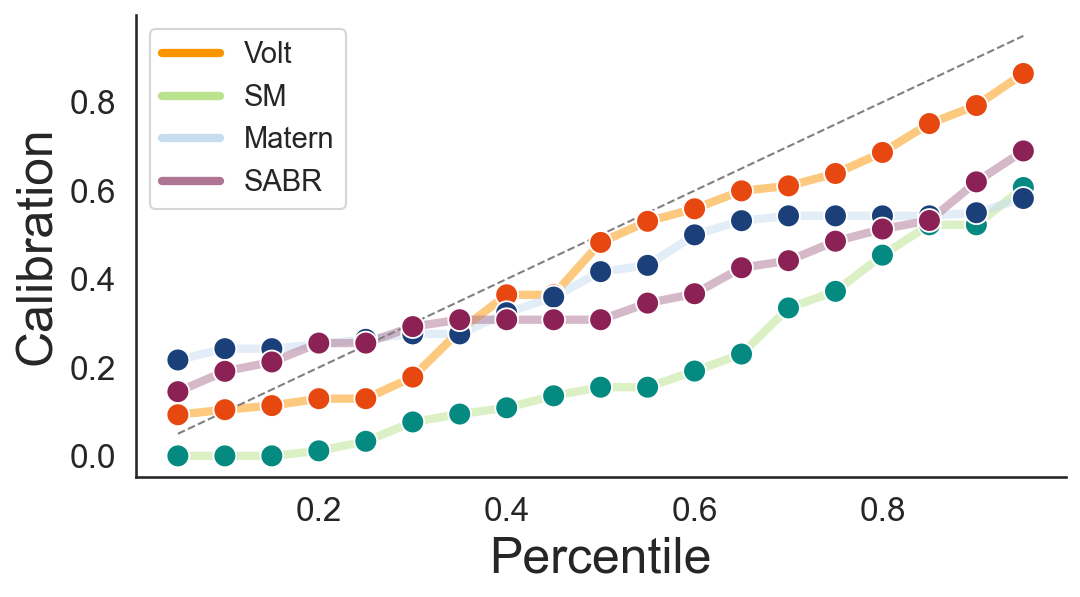

In [238]:
colors = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
fig, ax = plt.subplots(1,1,dpi=150, figsize=(8, 4))
sns.lineplot(x='Percentile', y="Calibration", hue='Type', data=df, ax=ax,
           palette=[colors[7], colors[3], colors[1], colors[5]], alpha=0.5)
sns.scatterplot(x='Percentile', y="Calibration", hue='Type', data=df, ax=ax,
           palette=[colors[6], colors[2], colors[0], colors[4]], s=120, legend=False, zorder=4)
# ax.get_legend().set_visible(False)
x = np.linspace(0.05,0.95)
y = np.linspace(0, len(pcts))
ax.plot(x, x, color="gray", lw=1., ls="--")
# ax.set_xticklabels(Rotation=45)
plt.tick_params(labelsize=16)
sns.despine()
plt.legend(fontsize=14, frameon="False")
# plt.label("Percentile")
plt.savefig("./calibration.pdf", bbox_inches="tight")
plt.show()

## Compute Bias of Bid/Ask

In [45]:
opts = pd.DataFrame()
for year in years:
    dat = pd.read_csv("./data/SPY_" + str(year) + ".csv")
    dat = dat[dat.type == "call"]
    quotedate = dat.quotedate.unique()[0]
    dat = dat[dat.quotedate == quotedate]    
    opts = pd.concat((opts, dat), ignore_index=True)

exps = [] 
for idx, row in opts.iterrows():
    eday = row.expiration
    exps.append(SPY[SPY.Date == FindLastTradingDays(SPY, [pd.Timestamp(eday)])[0]].Close.item())
opts['exp_price'] = exps

/Users/gregorybenton/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [46]:
ask_under_exp = (opts.ask < (opts.exp_price - opts.strike)).to_numpy()
bid_under_exp = (opts.bid < (opts.exp_price - opts.strike)).to_numpy()

types = []
for idx in range(ask_under_exp.shape[0]):
    if ask_under_exp[idx]:
        types.append("Above")
    elif bid_under_exp[idx]:
        types.append("Between")
    else:
        types.append("Below")
        
opts["Val"] = types

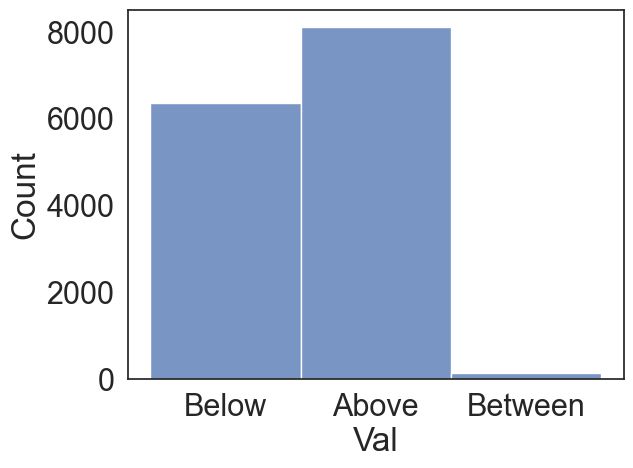

In [50]:
sns.histplot(x="Val", data=opts)
plt.show()

## Buy

In [74]:
mat_returns = FilteredReturns(matern)
sm_returns = FilteredReturns(sm)
volt_returns = FilteredReturns(voltron)
sabr_returns = FilteredReturns(sabr)
all_returns = (voltron.Return.to_numpy() - voltron.Ask.to_numpy())/voltron.Ask.to_numpy()

In [75]:
sm_returns.shape

(5134,)

In [76]:
volt_returns.shape

(5134,)

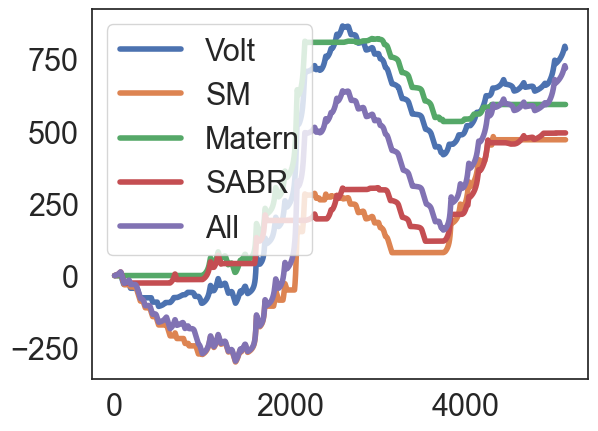

In [78]:
plt.plot(np.cumsum(volt_returns), label="Volt")
plt.plot(np.cumsum(sm_returns), label="SM")
plt.plot(np.cumsum(mat_returns), label="Matern")
plt.plot(np.cumsum(sabr_returns), label="SABR")
plt.plot(np.cumsum(all_returns), label="All")
plt.legend()
plt.show()

In [79]:
np.cumsum(volt_returns)[-1]

786.2182778724494

In [80]:
np.cumsum(all_returns)[-1]

718.9145160871468

## ITM

In [104]:
itm_dat = full_dat[full_dat.Strike < full_dat.Close]
rtn_pct = (itm_dat.Return - itm_dat.Ask)/itm_dat.Ask
volt_return = copy.deepcopy(rtn_pct)
volt_return[itm_dat.Model < itm_dat.Ask] = 0.

In [105]:
cum_rtn = np.cumsum(rtn_pct.to_numpy())
volt_cum_rtn = np.cumsum(volt_return.to_numpy())